# Deep learning - Karakterfelismerés az MNIST adathalmazzal a Tensorflow és Keras könyvtárakkal

In [55]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from matplotlib import pyplot as plt

In [177]:
(trainX, trainy), (testX, testy) = mnist.load_data()

## Az adat:
Összesen 70000 darab, $28\times 28$-as, szürkeárnyalatos kép a $0,1,2,3,4,5,6,7,8,9$ számjegyekről. Szeretnénk felismerni, hogy az egyes képek melyik számot ábrázolják. Szerencsére rendelkezésünkre áll minden képhez egy címke is, ami megmondja, hogy a kép mit tartalmaz. Az osztályaink száma tehát $C=10$. Ehhez készítünk egy neurális hálót, ami fel fogja ismerni (nagyjából), hogy mely képen milyen szám szerepel.

In [57]:
trainX.shape, trainy.shape, testX.shape, testy.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

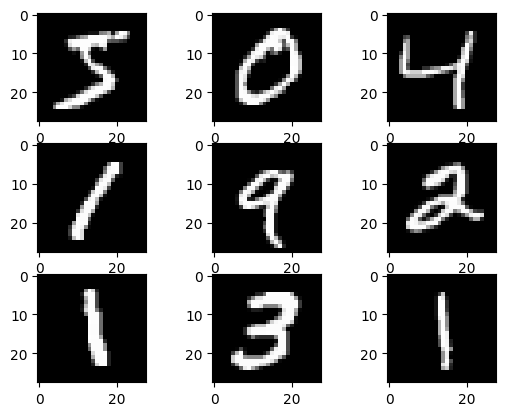

In [58]:
fig, ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(trainX[i*3+j], cmap="gray")

plt.show()


In [59]:
trainy[:9]

array([5, 0, 4, 1, 9, 2, 1, 3, 1], dtype=uint8)

In [60]:
trainX[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

### Normalizáljuk a rétegeket:
Átkonvertáljuk őket `float32` típusra, majd leosztjuk a maximális pixelintenzitással, ami 255. Így minden pixel értéke 0 és 1 közé fog esni.

In [61]:
trainX = trainX.astype("float32")/255
testX = testX.astype("float32")/255

In [62]:
trainX[0].min(), trainX[0].max()

(0.0, 1.0)

### Átalakítjuk a címkéket:
Az úgynevezett _one-hot_ kódolásra: egy $y$ címkét leképezünk az $y'\in\left\{0,1\right\}^C$ címkére, ahol $y'_i=\chi(y=i)$. Vagyis:
$$ 5\mapsto \left(0,0,0,0,0,1,0,0,0,0\right).$$

In [63]:
trainy = tf.keras.utils.to_categorical(trainy)
testy = tf.keras.utils.to_categorical(testy)

In [64]:
trainy[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [90]:
X = testX[0].reshape((1,28,28,1))
y = testy[0]

## Elkészítjük a modellt:
Valójában a modellünk egy nagy $f_\theta:\mathcal{X}\to\mathbb{R}^C$ függvény lesz, valamilyen $\theta$ paraméterekkel. A cél a megfelelő paraméterek megtalálása.

Egy szekvenciális modellt készítünk, ami azt jelenti nagyjából, hogy az $f_\theta$ függvényt egyéb függvények kompozíciójaként állítjuk elő:

$$
f_\theta = f_{\theta_1}∘f_{\theta_2}\circ\ldots\circ f_{\theta_n}
$$

Ezek a függvény alkotják a neurális háló _rétegeit_.

In [66]:
model = tf.keras.Sequential()

### Konvolúciós réteg:

Ez a típusú réteg gyakran használatos a _"gépi látás"_ területén, a részletekért nézd meg [ezt](https://towardsdatascience.com/gentle-dive-into-math-behind-convolutional-neural-networks-79a07dd44cf9).

In [67]:
conv_layer = tf.keras.layers.Conv2D(32,
                                 (3, 3),
                                 activation='relu',
                                 kernel_initializer='he_uniform',
                                 input_shape=(28, 28, 1))

In [68]:
conv_layer(X).shape

TensorShape([1, 26, 26, 32])

### Max pooling réteg:

A max pooling rétegről többet [itt](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/).

In [69]:
max_pooling_layer = tf.keras.layers.MaxPooling2D((2,2))

In [70]:
max_pooling_layer(conv_layer(X)).shape

TensorShape([1, 13, 13, 32])

### Flatten réteg:
"Kilapítjuk" a réteg inputját: az inputjából csinál egy darab sor vektort.

In [71]:
flatten_layer = tf.keras.layers.Flatten()

In [72]:
flatten_layer(max_pooling_layer(conv_layer(X)))

<tf.Tensor: shape=(1, 5408), dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

### Sűrű vagy teljesen kapcsolt vagy forward réteg:
A klasszikus réteg.


In [73]:
dense_layer_1 = tf.keras.layers.Dense(100,
                                      activation = "relu",
                                      kernel_initializer = "he_uniform")

In [74]:
dense_layer_1(flatten_layer(max_pooling_layer(conv_layer(X))))

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[1.1204057 , 0.        , 0.06362423, 0.        , 0.        ,
        0.        , 0.        , 0.26787287, 0.27410924, 0.77601486,
        0.        , 1.0820894 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.31525186, 0.        , 0.        , 1.0628434 , 0.68182886,
        0.        , 0.        , 0.        , 1.0584575 , 0.        ,
        0.        , 0.        , 0.        , 0.9342814 , 0.        ,
        0.4241376 , 0.        , 0.9820931 , 0.271628  , 0.        ,
        0.        , 0.0405885 , 0.69729716, 0.        , 0.        ,
        0.09306592, 1.2086456 , 0.4721086 , 0.        , 0.05408493,
        0.8815558 , 0.02764695, 0.81149447, 0.1641514 , 0.        ,
        0.        , 0.04282354, 1.3100371 , 0.4485425 , 0.44080132,
        0.        , 0.5515148 , 0.32936388, 0.20581546, 0.16482943,
        0.        , 0.        , 0.        , 0.        , 0.        

In [75]:
dense_layer_2 = tf.keras.layers.Dense(10,
                                      activation = "softmax")

In [76]:
dense_layer_2(dense_layer_1(flatten_layer(max_pooling_layer(conv_layer(X)))))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.11772177, 0.04808058, 0.11898989, 0.09170238, 0.06762356,
        0.2887253 , 0.0212456 , 0.04438127, 0.1282391 , 0.07329062]],
      dtype=float32)>

### Sztochasztikus gradiens módszer:
Jól bevált módszer, a részletek [itt](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

A `keras`-ban elérhető további optimalizáló eljárások megtalálhatók [itt](https://keras.io/api/optimizers/).

In [77]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01,
                              momentum=0.9)

In [78]:
model.add(conv_layer)
model.add(max_pooling_layer)
model.add(flatten_layer)
model.add(dense_layer_1)
model.add(dense_layer_2)

### Veszteségfüggvény: Kategorikus keresztentrópia
A következő lesz a veszteségfüggvényünk. Jelölje $f_\theta$ a neurális háló által reprezentált függvényt, legyen $x\in\mathcal{X}$ egy input, $y\in\mathbb{R}^C$ a hozzá tartozó címke és $s=f_\theta(x)$. Definiáljuk $\forall i=1,\ldots,C$-re a $\sigma_i:\mathbb{R}^C\to\mathbb{R}$ függvényt:
\begin{equation}
  s\mapsto \frac{\mathrm{e}^{s_i}}{\sum_{j=1}^C\mathrm{e}^{s_j}}
\end{equation}
Ekkor a kategorikus keresztentrópia az alábbi:
\begin{equation}
  \begin{array}{rcl}
    \mathcal{L}_{CCE}(x)& =& -\sum_{i=1}^C y_i\log(\sigma_i(x))\\
    & = & -\log\left(\frac{\mathrm{e}^{s_i}}{\sum_{j=1}^C\mathrm{e}^{s_j}}\right)
  \end{array}
\end{equation}
mivel $y_i=1$ pontosan akkor, ha $x$ az $i.$ kategóriába tartozik, különben $0$.

#### Metrika: pontosság
Azt méri, hogy a modell által javasolt címke

In [79]:
 model.compile(optimizer=opt,
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [128]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 5408)              0         
                                                                 
 dense_15 (Dense)            (None, 100)               540900    
                                                                 
 dense_16 (Dense)            (None, 10)                1010      
                                                                 
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
________________________________________________

### A tanítás:
Megadjuk neki a bemenetet és hozzájuk az elvár címkéket, majd 10-szer végigfuttatjuk a teljes tanító adaton. A `batch_size` mondja meg, hogy hány inputonként végezzen el egy javítást az optimalizáló. A túl kicsi batch túl sok munkát ad az optimalizálónak, a túl nagy batch viszont "szétkeni" a javításokat. Leggyakrabban 2-hatványnak szokás megválasztani a méretét.

In [80]:
model.fit(trainX,
          trainy,
          epochs=10,
          batch_size=512,
          verbose=True)

Epoch 1/10
118/118 [==============================] - 4s 7ms/step - loss: 0.4355 - accuracy: 0.8709
Epoch 2/10
118/118 [==============================] - 1s 6ms/step - loss: 0.2036 - accuracy: 0.9411
Epoch 3/10
118/118 [==============================] - 1s 6ms/step - loss: 0.1578 - accuracy: 0.9545
Epoch 4/10
118/118 [==============================] - 1s 6ms/step - loss: 0.1329 - accuracy: 0.9620
Epoch 5/10
118/118 [==============================] - 1s 6ms/step - loss: 0.1121 - accuracy: 0.9685
Epoch 6/10
118/118 [==============================] - 1s 7ms/step - loss: 0.0980 - accuracy: 0.9729
Epoch 7/10
118/118 [==============================] - 1s 7ms/step - loss: 0.0864 - accuracy: 0.9766
Epoch 8/10
118/118 [==============================] - 1s 6ms/step - loss: 0.0760 - accuracy: 0.9794
Epoch 9/10
118/118 [==============================] - 1s 6ms/step - loss: 0.0703 - accuracy: 0.9810
Epoch 10/10
118/118 [==============================] - 1s 6ms/step - loss: 0.0637 - accuracy: 0.9827

### Kiértékeljük a tesztadaton:

In [33]:
model.evaluate(testX, testy)

313/313 [==============================] - 1s 4ms/step - loss: 0.0644 - accuracy: 0.9805


[0.06437385082244873, 0.9804999828338623]

### Kiértékeljük egy darab inputon:

In [81]:
model(X), y

(<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[5.95481936e-07, 1.27879417e-07, 5.85866437e-05, 1.05433435e-04,
         2.41944753e-09, 3.86528257e-07, 1.52746270e-11, 9.99804437e-01,
         2.25614167e-05, 7.96566019e-06]], dtype=float32)>,
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32))

# Feladat: LeNet-5
Valósítsd meg a [LeNet-5](https://en.wikipedia.org/wiki/LeNet)-öt és tanítsd be az MNIST adathalmazon! 
Részfeladatok:
* Alakítsd át úgy a tanító adatot (`trainX`), hogy explicit 1-csatornás legyen, vagyis hogy `trainX.shape = (60000, 28, 28, 1)`. Ezt pl. a `tf.expand_dim()` függvénnyel tudod megtenni.
* Készíts egy szekvenciális modellt!
* Legyen az első rétege egy `ZeroPadding2d`, a pedding értéke pedig 2 minden irányban.
* Készítsd el az [itt](https://en.wikipedia.org/wiki/Convolutional_neural_network#/media/File:Comparison_image_neural_networks.svg) látható architektúrát. (Az első konvolúciós rétegnél a +2 padding az, amit a `ZeroPadding2D` réteggel megcsinálunk).
* Példányosíts egy stochasztikus gradiens optimalizálót, pl. az előző hálónál használt paraméterekkel (kísérletezhetsz vele, hogy különböző paramétereknél mi történik).
* Konfiguráld a modellt a tanításhoz az optimalizálóval, a veszteségfüggvény legyen itt is `categorical_crossentropy`, és a teljesítmény mérésére használt metrika legyen itt is a pontosság!
* Tanítsd be a modellt! Kísérletezz különböző batch méretekkel és az epochok számával.

További olvasnivaló a modellről [itt](https://arnabfly.github.io/arnab_blog/lenet5/).

In [ ]:
trainX = tf.expand_dims(trainX, axis=3)

In [ ]:
LeNet = tf.keras.Sequential(name="LeNet-5")

In [ ]:
LeNet.add(tf.keras.layers.ZeroPadding2D(padding=(2,2)))

LeNet.add(tf.keras.layers.Conv2D(filters=6,
                                 kernel_size=(5,5),
                                 activation="sigmoid",
                                 input_shape=(32,32,1),
                                 padding="valid"))

LeNet.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2),
                                           strides=2))

LeNet.add(tf.keras.layers.Conv2D(filters=16,
                                 kernel_size=(5,5),
                                 activation="sigmoid",
                                 strides=(1,1),
                                 input_shape=(14,14,6)))

LeNet.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2),
                                           strides=2))

LeNet.add(tf.keras.layers.Flatten())

LeNet.add(tf.keras.layers.Dense(120,
                                activation="sigmoid"))

LeNet.add(tf.keras.layers.Dense(84,
                                activation="sigmoid"))

LeNet.add(tf.keras.layers.Dense(10,
                                activation="sigmoid"))

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01,
                              momentum=0.9)

In [ ]:
LeNet.compile(optimizer=opt,
               loss="categorical_crossentropy",
               metrics=['accuracy'])

In [ ]:
history = LeNet.fit(trainX,
                    trainy,
                    epochs=10,
                    batch_size=64,
                    verbose=True)

In [ ]:
LeNet.summary()

In [ ]:
plt.plot(history.history["accuracy"])
plt.show()

In [ ]:
LeNet.evaluate(testX,
               testy)